In [1]:
import numpy as np
import matplotlib.pyplot as plt
from probDE.car import car_init
from probDE.utils.utils import rand_mat, indep_init
from scipy.integrate import odeint
from probDE.cython.KalmanODE_blas import KalmanODE as KalmanODE_blas
from probDE.cython.KalmanODE import KalmanODE
from KalmanODE_py import KalmanODE_py

In [2]:
from math import sin
from scipy import integrate
def ode_py(x_t, t, theta=None):
    return np.array([sin(2*t) - x_t[0]])

# ode function in odeint format
def f(x_t, t):
    return [x_t[1], sin(2*t) - x_t[0]]

In [3]:
# LHS vector of ODE
w_vec = np.array([0.0, 0.0, 1.0])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 1
n_state = 4

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 50
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 50
sigma = .5

# Initial value, x0, for the IVP
x0 = np.array([-1., 0., 1.])

# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# All necessary parameters are in kinit, namely, T, c, R, W
kinit, x0_state = indep_init([car_init(n_state, tau, sigma, dt, w_vec, x0)], n_state)

In [4]:
z_states = rand_mat(2*(n_eval+1), n_state)
kalmanode = KalmanODE_blas(n_state, n_meas, tmin, tmax, n_eval, ode_py, **kinit)
kalmanode.z_states = z_states
kalman_sim, _, _ = kalmanode.solve(x0_state, mv=True, sim=True)

In [5]:
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, ode_py, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
k_sim, k_mu, k_var = kalmanode_py.solve(x0_state, mv=True, sim=True)

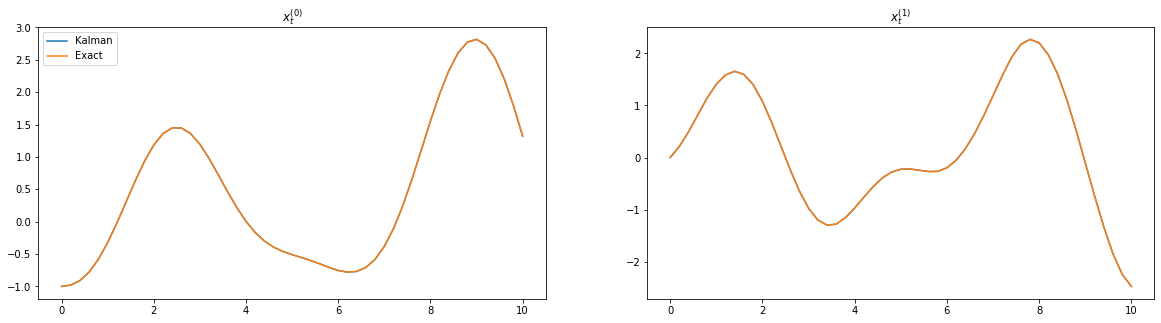

In [6]:
tseq = np.linspace(tmin, tmax, n_eval+1)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(tseq, k_sim[:,0], label = 'Kalman')
axs[0].plot(tseq, kalman_sim[:, 0], label = 'Exact')
axs[0].set_title("$x^{(0)}_t$")
axs[0].legend(loc='upper left')
axs[1].plot(tseq, k_sim[:,1], label = 'Kalman')
axs[1].plot(tseq, kalman_sim[:, 1], label = 'Exact')
axs[1].set_title("$x^{(1)}_t$")
plt.show()

In [7]:
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, ode_py, **kinit) # Initialize the class
kalmanode.z_states = z_states
kalman_c = %timeit -o -n 100 _ = kalmanode.solve(x0_state, mv=False, sim=True)

286 µs ± 37 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
kalmanode = KalmanODE_blas(n_state, n_meas, tmin, tmax, n_eval, ode_py, **kinit) # Initialize the class
kalmanode.z_states = z_states
kalman_cy = %timeit -o -n 100 _ = kalmanode.solve(x0_state, mv=False, sim=True)

935 µs ± 35.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, ode_py, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_py = %timeit -o -n 100 _ = kalmanode_py.solve(x0_state, mv=False, sim=True)

9.2 ms ± 409 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
print("Cython is {}x faster than Python".format(kalman_py.average/kalman_cy.average))
print("C++ is {}x faster than Cython".format(kalman_cy.average/kalman_c.average))

Cython is 9.838428952639694x faster than Python
C++ is 3.2694955125470595x faster than Cython


## Lorenz63

In [12]:
def lorenz0(X_t, t, theta=(28, 10, 8/3)):
    rho, sigma, beta = theta
    p = 3
    x, y, z = X_t[0], X_t[1], X_t[2]
    return np.array([-sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y]) 

In [13]:
# RHS of ODE
def lorenz(X_t, t, theta=(28, 10, 8/3)):
    rho, sigma, beta = theta
    p = 2
    x, y, z = X_t[p*0], X_t[p*1], X_t[p*2]
    return np.array([-sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y])

# LHS Matrix of ODE
w_mat = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 3
n_state = 6 # number of continuous derivatives of CAR(p) solution prior
n_state1 = n_state2 = n_state3 = 2
n_var_states = np.array([n_state1, n_state2, n_state3])

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 5000
tmin = 0
tmax = 20
theta=(28, 10, 8/3)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = np.array([1.3, 1.3, 1.3])
sigma = np.array([.5, .5, .5])

# Initial value, x0, for the IVP
x0 = [-12, -5, 38]
v0 = [70, 125, -124/3]
x0 = np.column_stack([x0, v0])

In [14]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# Initialize CAR with three variables
kinit, x0_state = indep_init([car_init(n_state1, tau[0], sigma[0], dt, w_mat[0], x0[0]),
                        car_init(n_state2, tau[1], sigma[1], dt, w_mat[1], x0[1]),
                        car_init(n_state3, tau[2], sigma[2], dt, w_mat[2], x0[2])], n_state)

# Initialize the Kalman class
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, lorenz, **kinit)
# Run the solver to get an approximation
kalman_lor_sim = kalmanode.solve(x0_state, theta, mv=False, sim=True)

In [15]:
z_states = rand_mat(2*(n_eval+1), n_state)
kalmanode_c = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, lorenz, **kinit) # Initialize the class
kalmanode_c.z_states = z_states
kalman_lor_c = %timeit -o _ = kalmanode_c.solve(x0_state, theta, mv=False, sim=True)
kalmanode = KalmanODE_blas(n_state, n_meas, tmin, tmax, n_eval, lorenz, **kinit)
kalmanode.z_states = z_states
kalman_lor_cy = %timeit -o _ = kalmanode.solve(x0_state, theta, mv=False, sim=True)
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, lorenz, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_lor_py = %timeit -o _ = kalmanode_py.solve(x0_state, theta, mv=False, sim=True)
print('py/cy: {}'.format(kalman_lor_py.average/kalman_lor_cy.average))
print('cy/c: {}'.format(kalman_lor_cy.average/kalman_lor_c.average))

56.7 ms ± 5.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
115 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.17 s ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
py/cy: 10.220111745436657
cy/c: 2.020405366267664
